# Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import gensim  # para cargar modelo w2v
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import plot_model

2025-05-03 17:17:36.604488: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_csv("deceptive-opinion.csv", usecols=['polarity','text'])
data.head(10)

,polarity,text
0,positive,We stayed for a one night getaway with family ...
1,positive,Triple A rate with upgrade to view room was le...
2,positive,This comes a little late as I'm finally catchi...
3,positive,The Omni Chicago really delivers on all fronts...
4,positive,I asked for a high floor away from the elevato...
5,positive,I stayed at the Omni for one night following a...
6,positive,We stayed in the Conrad for 4 nights just befo...
7,positive,Just got back from 2 days up in Chicago shoppi...
8,positive,We arrived at the Omni on 2nd September for a ...
9,positive,"On our visit to Chicago, we chose the Hyatt du..."


In [20]:
import re

def remove_puntuacion(text):
  """Elimina la puntuación pero conserva los números del texto."""
  new_text = re.sub(r'[^\w\s]+', '', text)  # Elimina todo lo que no sea alfanumérico o espacio
  return new_text

In [30]:
# Convert text to lower case
data['text'] = data['text'].str.lower()
data['text_p'] = data['text'].apply(remove_puntuacion)
# Estimate lenght of text review
data['long_text'] = data['text_p'].str.split().str.len()
data.head(10)
     

,polarity,text,long_text,text_idx,text_p
0,positive,we stayed for a one night getaway with family ...,105,"[9, 44, 10, 4, 46, 80, 886, 18, 247, 23, 4, 75...",we stayed for a one night getaway with family ...
1,positive,triple a rate with upgrade to view room was le...,44,"[3476, 4, 325, 18, 806, 3, 133, 15, 6, 457, 84...",triple a rate with upgrade to view room was le...
2,positive,this comes a little late as i'm finally catchi...,207,"[22, 1118, 4, 195, 411, 32, 264, 203, 5245, 57...",this comes a little late as im finally catchin...
3,positive,the omni chicago really delivers on all fronts...,127,"[1, 329, 35, 92, 5246, 23, 40, 7586, 34, 1, 75...",the omni chicago really delivers on all fronts...
4,positive,i asked for a high floor away from the elevato...,72,"[5, 138, 10, 4, 239, 178, 224, 34, 1, 503, 2, ...",i asked for a high floor away from the elevato...
5,positive,i stayed at the omni for one night following a...,178,"[5, 44, 12, 1, 329, 10, 46, 80, 1409, 4, 110, ...",i stayed at the omni for one night following a...
6,positive,we stayed in the conrad for 4 nights just befo...,111,"[9, 44, 7, 1, 377, 10, 337, 189, 55, 167, 5255...",we stayed in the conrad for 4 nights just befo...
7,positive,just got back from 2 days up in chicago shoppi...,131,"[55, 71, 93, 34, 149, 350, 57, 7, 35, 287, 18,...",just got back from 2 days up in chicago shoppi...
8,positive,we arrived at the omni on 2nd september for a ...,164,"[9, 151, 12, 1, 329, 23, 1948, 1949, 10, 4, 81...",we arrived at the omni on 2nd september for a ...
9,positive,"on our visit to chicago, we chose the hyatt du...",84,"[23, 24, 256, 3, 166, 9, 588, 1, 361, 578, 3, ...",on our visit to chicago we chose the hyatt due...


In [31]:
# Get Vocabulary
def vocabulary(pandas_series):
    lista_palabras = " ".join(sec for sec in pandas_series).split(" ")
    x = Counter(lista_palabras)

    return [i for i,_ in x.most_common() ]

In [32]:
vocabulary_words = vocabulary(data['text_p'])
vocabulary_words

['the',
 'and',
 'to',
 'a',
 'i',
 'was',
 'in',
 'of',
 'hotel',
 'we',
 'for',
 'room',
 'it',
 'at',
 'my',
 'is',
 'that',
 'with',
 'were',
 'not',
 'had',
 'this',
 'on',
 'chicago',
 'but',
 'our',
 'they',
 'very',
 'stay',
 'have',
 'there',
 'you',
 'be',
 'as',
 'from',
 'when',
 'would',
 'all',
 'great',
 'so',
 'staff',
 'me',
 'are',
 'service',
 '',
 'one',
 'rooms',
 'stayed',
 'an',
 'out',
 'no',
 'up',
 'us',
 'if',
 'like',
 'get',
 '\n',
 'will',
 'just',
 'night',
 'time',
 'desk',
 'about',
 'nice',
 'or',
 'location',
 'after',
 'did',
 'even',
 'by',
 'which',
 'could',
 'bed',
 'only',
 'also',
 'here',
 'clean',
 'good',
 'got',
 'what',
 'again',
 'front',
 'their',
 'back',
 'more',
 'some',
 'been',
 'first',
 'place',
 'hotels',
 'its',
 'bathroom',
 'next',
 'other',
 'well',
 'than',
 'day',
 'didnt',
 'experience',
 'really',
 'two',
 'because',
 'never',
 'made',
 'friendly',
 'comfortable',
 'go',
 'recommend',
 'business',
 'has',
 'do',
 'lobby',

In [33]:
# Get vocabulary  Unique words
len(vocabulary_words)

10977

In [34]:
#Map words to tokens

def get_dict_map(token_or_tag):
    if token_or_tag == 'token':
        # agregamos 'PAD_token' al vocabulario de tokens, para ser usado más
        # adelante a fin de que todas las oraciones tengan la misma cantidad de
        # tokens
        vocab = ['PAD_token'] + [token for token in vocabulary(data['text_p']) if token is not None] 
    elif token_or_tag == 'tag':
        vocab = vocabulary(data['Tags'])

    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map('token')
print(token2idx['PAD_token'])
print(len(token2idx))   


0
10978


In [35]:
data['text_idx'] = data['text_p'].apply(lambda x: list(map(token2idx.get, x.split())))

<Axes: >

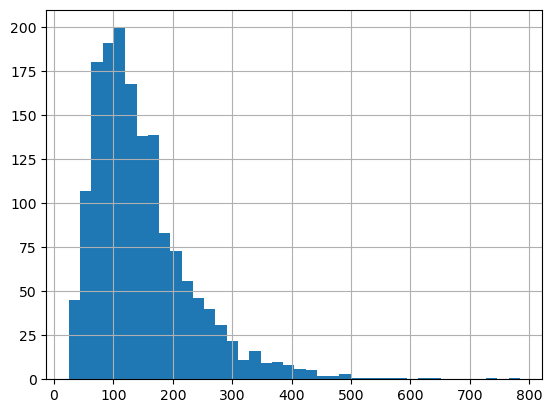

In [36]:
#Histogram with reviews lenght
data['long_text'].hist(bins=40) 

In [38]:
# Estimate percentiles
custom_percentiles = list(range(5, 101,5))
custom_percentile_values = np.percentile(data['long_text'], custom_percentiles)
percentile_table = pd.DataFrame({
    'Percentile': custom_percentiles,
    'Value': custom_percentile_values
})
print(percentile_table)

    Percentile   Value
0            5   52.00
1           10   63.00
2           15   72.00
3           20   81.00
4           25   88.00
5           30   96.00
6           35  104.00
7           40  112.00
8           45  119.00
9           50  127.00
10          55  137.00
11          60  147.00
12          65  159.35
13          70  170.00
14          75  182.00
15          80  203.00
16          85  226.00
17          90  260.00
18          95  311.05
19         100  784.00


In [39]:
# Define max lenght
max_len = int(data['long_text'].quantile(0.95))
max_len

311

In [40]:
data.head(10)

,polarity,text,long_text,text_idx,text_p
0,positive,we stayed for a one night getaway with family ...,105,"[10, 48, 11, 4, 46, 60, 605, 18, 244, 23, 4, 1...",we stayed for a one night getaway with family ...
1,positive,triple a rate with upgrade to view room was le...,44,"[2870, 4, 282, 18, 606, 3, 116, 12, 6, 451, 96...",triple a rate with upgrade to view room was le...
2,positive,this comes a little late as i'm finally catchi...,207,"[22, 1086, 4, 209, 386, 34, 261, 188, 4067, 52...",this comes a little late as im finally catchin...
3,positive,the omni chicago really delivers on all fronts...,127,"[1, 325, 24, 100, 3357, 23, 38, 4069, 35, 1, 5...",the omni chicago really delivers on all fronts...
4,positive,i asked for a high floor away from the elevato...,72,"[5, 158, 11, 4, 247, 120, 184, 35, 1, 441, 2, ...",i asked for a high floor away from the elevato...
5,positive,i stayed at the omni for one night following a...,178,"[5, 48, 14, 1, 325, 11, 46, 60, 1312, 4, 109, ...",i stayed at the omni for one night following a...
6,positive,we stayed in the conrad for 4 nights just befo...,111,"[10, 48, 7, 1, 345, 11, 323, 161, 59, 155, 336...",we stayed in the conrad for 4 nights just befo...
7,positive,just got back from 2 days up in chicago shoppi...,131,"[59, 79, 84, 35, 150, 269, 52, 7, 24, 206, 18,...",just got back from 2 days up in chicago shoppi...
8,positive,we arrived at the omni on 2nd september for a ...,164,"[10, 131, 14, 1, 325, 23, 1768, 1314, 11, 4, 6...",we arrived at the omni on 2nd september for a ...
9,positive,"on our visit to chicago, we chose the hyatt du...",84,"[23, 26, 214, 3, 24, 10, 621, 1, 343, 587, 3, ...",on our visit to chicago we chose the hyatt due...


In [42]:

# Print the entire 'text_idx' column
print("Contents of data['text_idx']:")
print(data['text_idx'])

# Another way to check for None within lists (more concise)
print("\nConcise check for None within lists in data['text_idx']:")
has_none = False
for index, text_indices in data['text_idx'].items():
    if isinstance(text_indices, list) and any(value is None for value in text_indices):
        print(f"List at DataFrame index {index} contains None values.")
        print(data.loc[index]['text_p'])
        has_none = True
    elif text_indices is None:
        print(f"The entire entry at DataFrame index {index} is None")
        has_none = True

if not has_none:
    print("\nNo None values found within the lists in data['text_idx'].")

Contents of data['text_idx']:
0       [10, 48, 11, 4, 46, 60, 605, 18, 244, 23, 4, 1...
1       [2870, 4, 282, 18, 606, 3, 116, 12, 6, 451, 96...
2       [22, 1086, 4, 209, 386, 34, 261, 188, 4067, 52...
3       [1, 325, 24, 100, 3357, 23, 38, 4069, 35, 1, 5...
4       [5, 158, 11, 4, 247, 120, 184, 35, 1, 441, 2, ...
                              ...                        
1595    [429, 687, 36, 5, 147, 1, 428, 24, 535, 14, 1,...
1596    [1, 380, 9, 110, 4, 159, 314, 2, 1851, 2648, 2...
1597    [1, 428, 24, 395, 301, 1, 402, 8, 1, 9, 358, 1...
1598    [1, 486, 362, 177, 115, 13, 685, 78, 7, 757, 2...
1599    [34, 4, 4229, 10975, 261, 2262, 14, 1, 380, 9,...
Name: text_idx, Length: 1600, dtype: object

Concise check for None within lists in data['text_idx']:
List at DataFrame index 403 contains None values.
conrad chicago it was 500 am my plan just flew in and i was tired i checked myself into the confad chicago when i first got there there was a creepy employe the floor was filthy bu

In [16]:
#data.loc[407]['text_idx']
print(data.loc[403]['text'])
print(data.loc[403]['text_idx'])

conrad chicago it was 5:00 am my plan just flew in and i was tired i checked myself into the confad chicago when i first got there there was a creepy employe the floor was filthy but i got my room in the 5th level of then as i dashed towards the elevator my suite case in hand i entered it then that's where i started to see the beauti of the place the walls where polished wood there was even a small ac/heater unit and it was good. then out of no where ting i made it up there this place was great the carpets where velveteen it was a true luxurious hotel i found my rooms and was greeted to a golden door nob i was living in paradise after i got into my room it was a perfect! the room was a perfect 68 degrees. i was shocked to find how confrotable the bed was... perfect! and it had leather pillows and a huge blanket then just when i didn't think it could get any better i look my bathroom its perfect stone and gold! the water actually has a good taste to it like grapes i was so shocked i fel

In [15]:
# Padding
pad_tokens = pad_sequences(data['text_idx'], maxlen= max_len,
                           dtype='int32', padding='post',
                           value = token2idx['PAD_token'])

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'